## make semi supervised

In [2]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2

Loading BokehJS ...

In [3]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
dataset = read_h5ad("temp/celligner_multi.h5ad.gz")

In [162]:
Counter(dataset.obs.tissue_type)

Counter({'lung': 1308,
         'soft_tissue': 552,
         'skin': 557,
         'bile_duct': 79,
         'urinary_tract': 443,
         'colorectal': 454,
         'lymphocyte': 181,
         'uterus': 278,
         'gastric': 461,
         'kidney': 1057,
         'pancreas': 232,
         'central_nervous_system': 1307,
         'fibroblast': 39,
         'breast': 1160,
         'bone': 302,
         'upper_aerodigestive': 576,
         'ovary': 491,
         'cervix': 325,
         'blood': 1221,
         'esophagus': 214,
         nan: 25,
         'liver': 422,
         'peripheral_nervous_system': 212,
         'eye': 92,
         'thyroid': 532,
         'plasma_cell': 29,
         'engineered_central_nervous_system': 1,
         'embryo': 3,
         'engineered_kidney': 2,
         'prostate': 507,
         'engineered_ovary': 1,
         'engineered': 6,
         'engineered_prostate': 1,
         'engineered_lung': 1,
         'adrenal_cortex': 1,
         'engineered_b

In [5]:
dataset.obs.cell_type = dataset.obs.cell_type.replace({'historical_CL; 2D':'historical_cl'})

In [6]:
rename = {np.nan: "unknown", "adrenal_cortex": "adrenal", "colorectal": "colon", 'thymus': 'thyroid',}
dataset.obs.tissue_type = dataset.obs.tissue_type.replace(rename)

In [7]:
for val in ['ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

ends {'paired end'}
reference {'hg38'}
method {'bulk'}
sequencer {'Illumina Hiseq 2000'}


In [8]:
loc = np.argsort(dataset.X.var(0))[-3000:]
dataset = AnnData(dataset.X[:,loc], dataset.obs, dataset.var.iloc[loc])

In [9]:
set(dataset.obs.sex)

{'Female', 'Male', 'U', 'female', 'male', nan, 'not reported', 'unknown'}

In [10]:
dataset.obs.sex = dataset.obs.sex.str.lower()

In [11]:
for val in ['tissue_type', 'age', "sex", 'disease_type']:  
    loc = dataset.obs[val].isin(['unknown', 'not reported', 'Unknown', 'u']) | dataset.obs[val].isna()
    try:
        dataset.obs.loc[loc, val] = 'U'
    except ValueError:
        dataset.obs[val] = dataset.obs[val].cat.add_categories('U')
        dataset.obs.loc[loc, val] = 'U'

In [12]:
# removing ultra rare samples
loc = dataset.obs["disease_type"].isin([
'Teratoma',
'Thymic Cancer',
'Nasopharyngeal Cancer',
'U',
'Endocrine Cancer',
'Pineal Cancer',
'Embryonal Cancer',
"Gallbladder Cancer"]) | dataset.obs["tissue_type"].isin([
'engineered_central_nervous_system',
'embryo',
'engineered_kidney',
'engineered_ovary',
'engineered',
'engineered_prostate',
'engineered_lung',
'adrenal_cortex',
'engineered_blood',
'engineered_breast',
'colon',
'nasopharynx',
'teratoma',
'endocrine',
'pineal'])

dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc])

In [12]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [13]:
loc = dataset.obs.cell_type=='tumor'
subdataset = AnnData(dataset.X[loc.values], dataset.obs[loc])

In [14]:
set(dataset.obs.sex)

{'U', 'female', 'male'}

In [16]:
toprovide = dataset.copy()
toprovide.obs.loc[toprovide.obs.cell_type=="historical_cl",['tissue_type', 'age', "sex", 'disease_type']] = ["U","U","U","U"]

In [ ]:
cl2_less = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=['cell_type'],
    predictor_keys=['tissue_type', 'age', "sex", 'disease_type'],
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32,64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8
)
cl2_less.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 2
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 65 

Decoder Architecture:
	First Layer in, out and cond:  16 128 2
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
adata_latent.obs

In [28]:
cl2_less.condition_keys_

['cell_type']

In [54]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2_less)

In [55]:
evaluator.get_class_quality(classes=['tissue_type', 'disease_type', 'sex', 'age'])

tissue_type
all predicted categories:  {'blood', 'upper_aerodigestive', 'central_nervous_system', 'ovary', 'uterus', 'eye', 'gastric', 'breast', 'kidney', 'soft_tissue', 'fibroblast', 'adrenal', 'prostate', 'liver', 'pancreas', 'esophagus', 'cervix', 'urinary_tract', 'thyroid', 'bone', 'germ_cell', 'lung', 'skin', 'bile_duct', 'peripheral_nervous_system', 'nerve', 'plasma_cell', 'lymphocyte'}
accuracy:  0.9912460988049022
F1 Score: 0.98


disease_type
all predicted categories:  {'Skin Cancer', 'Liver Cancer', 'Adrenal Cancer', 'Rhabdoid', 'Neuroblastoma', 'Gastric Cancer', 'Lymphoma', 'Esophageal Cancer', 'Bile Duct Cancer', 'Bladder Cancer', 'Liposarcoma', 'Thymus Cancer', 'normal', 'Germ Cell Cancer', 'Nerve', 'Lung Cancer', 'Leukemia', 'Myeloma', 'Kidney Cancer', 'Thyroid Cancer', 'Ovarian Cancer', 'Brain Cancer', 'Cervical Cancer', 'Prostate Cancer', 'Endometrial/Uterine Cancer', 'Pancreatic Cancer', 'Breast Cancer', 'Head and Neck Cancer', 'Bone Cancer', 'Sarcoma', 'Eye Cancer'}
a

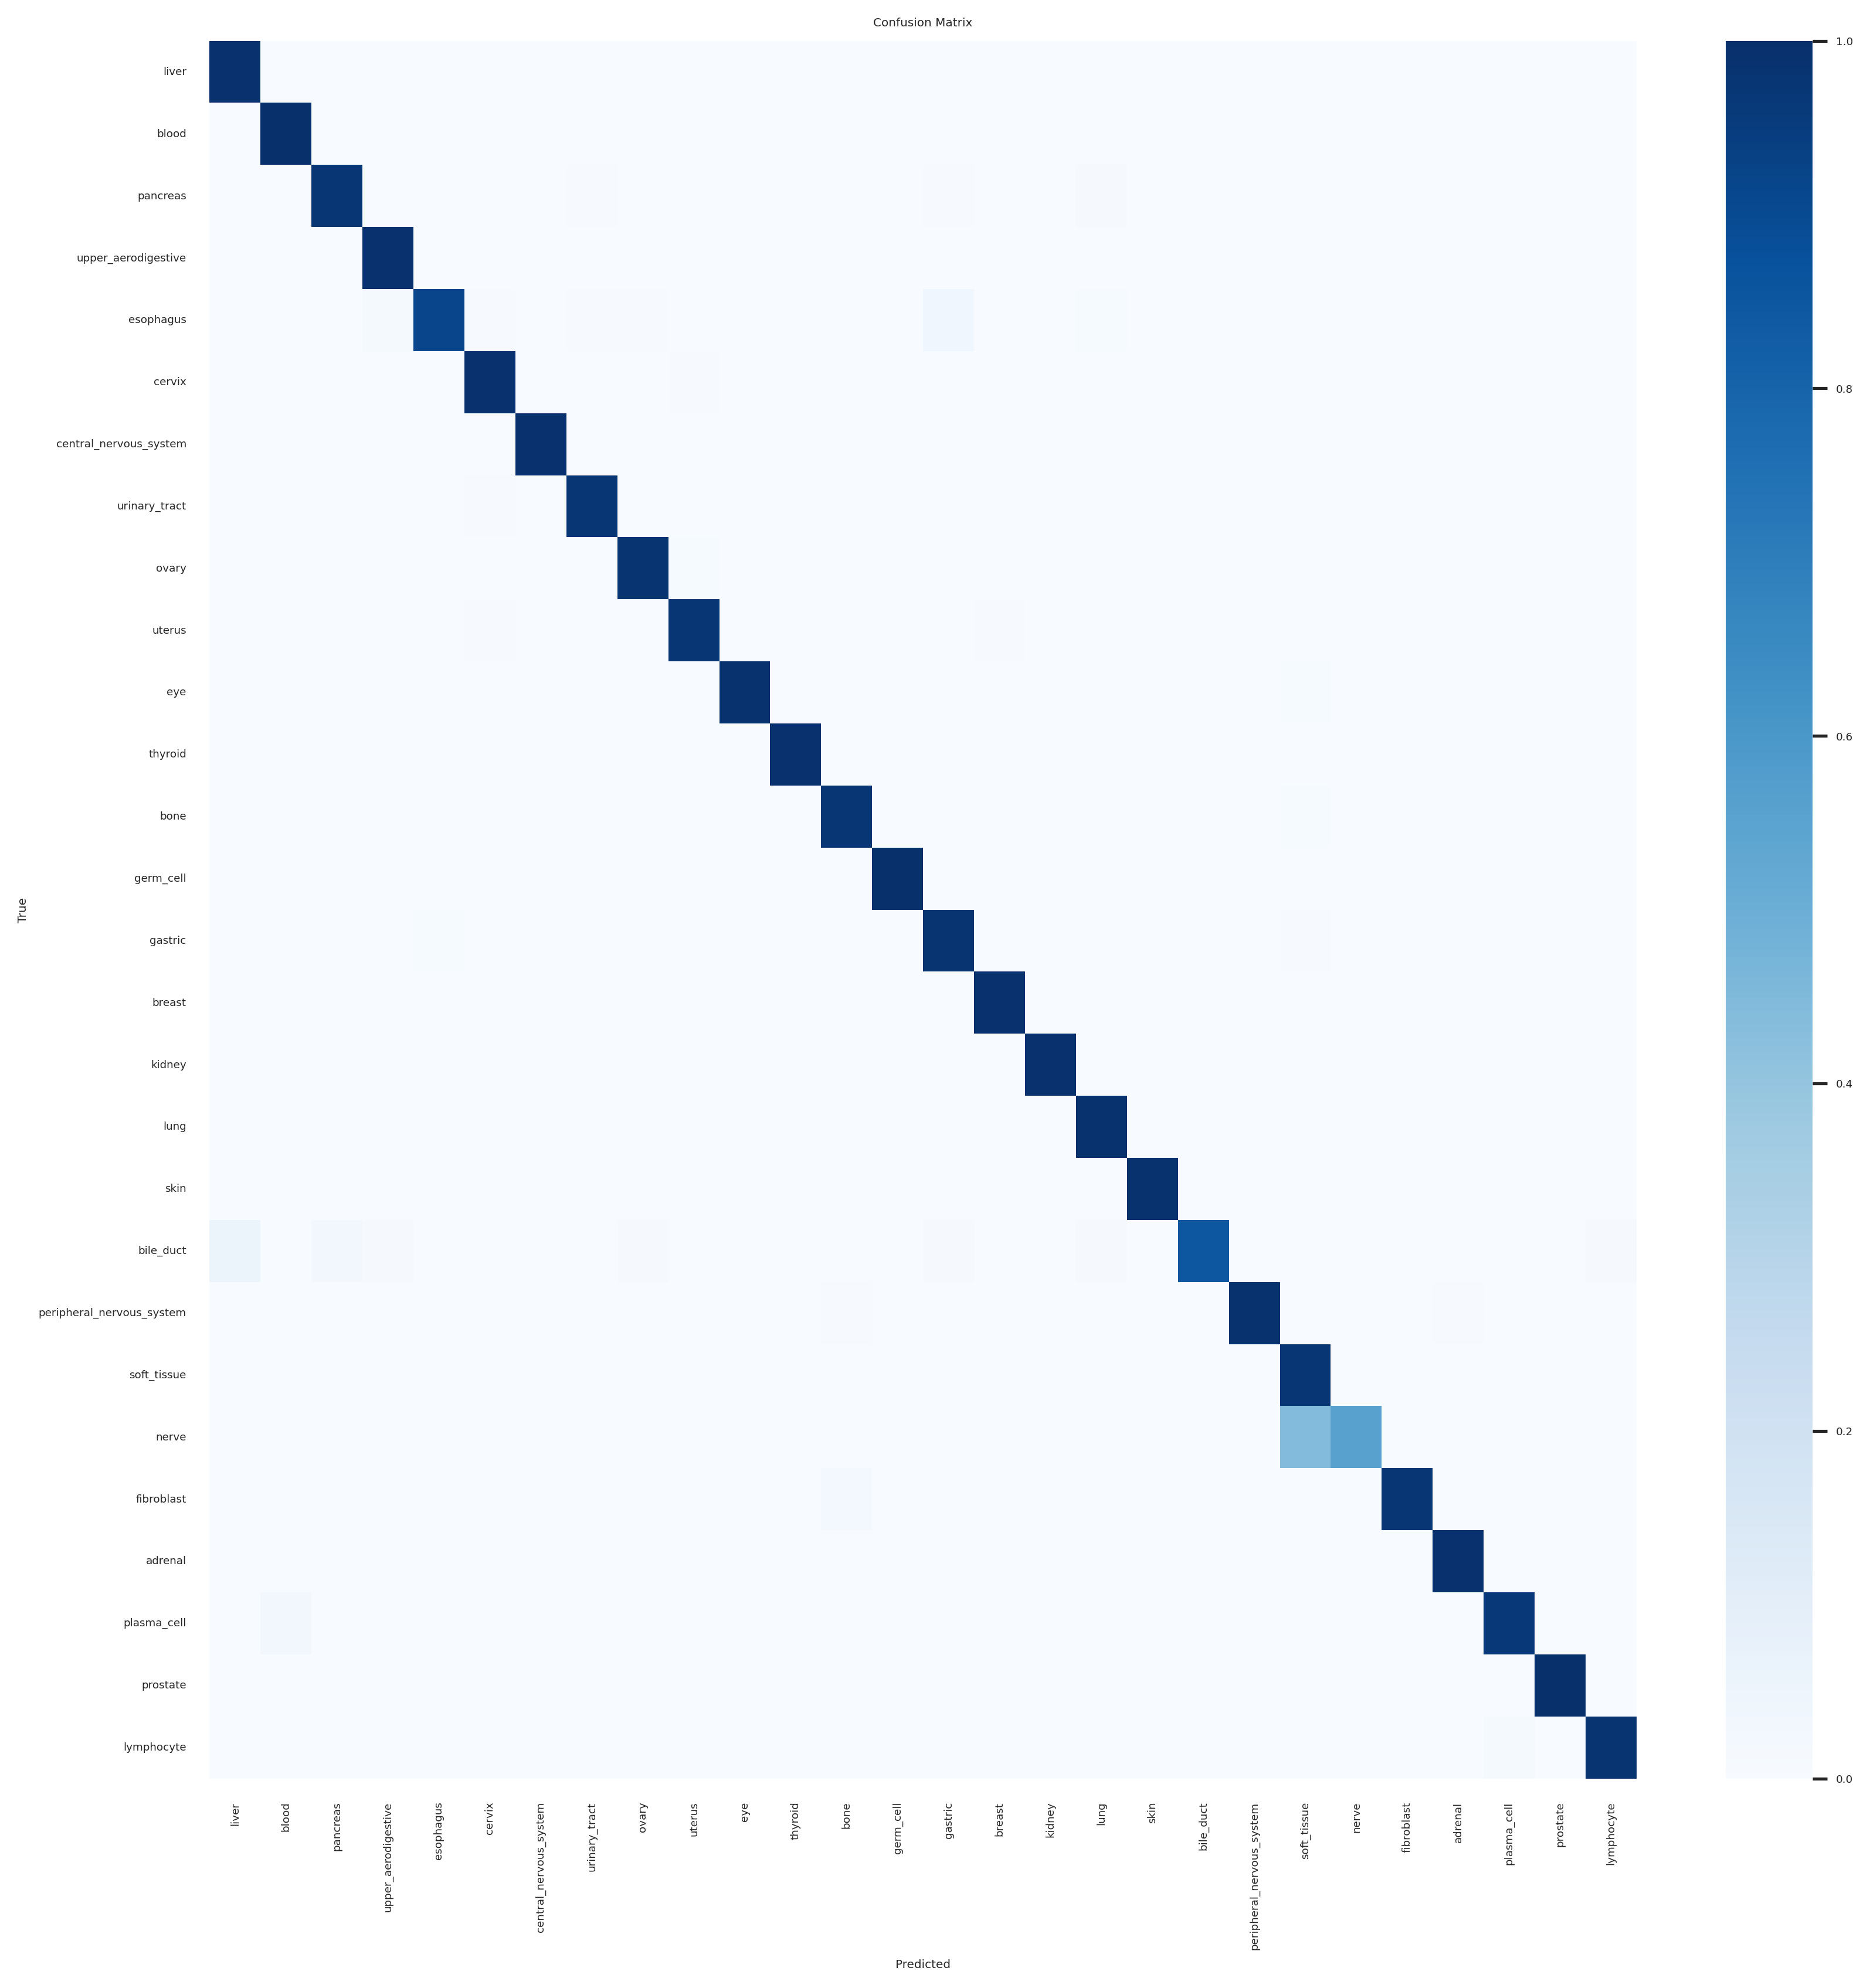

In [31]:
conf = evaluator.getconfusionMatrix(only=None)

In [ ]:
conf = evaluator.getconfusionMatrix(only="historical_cl")

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will 

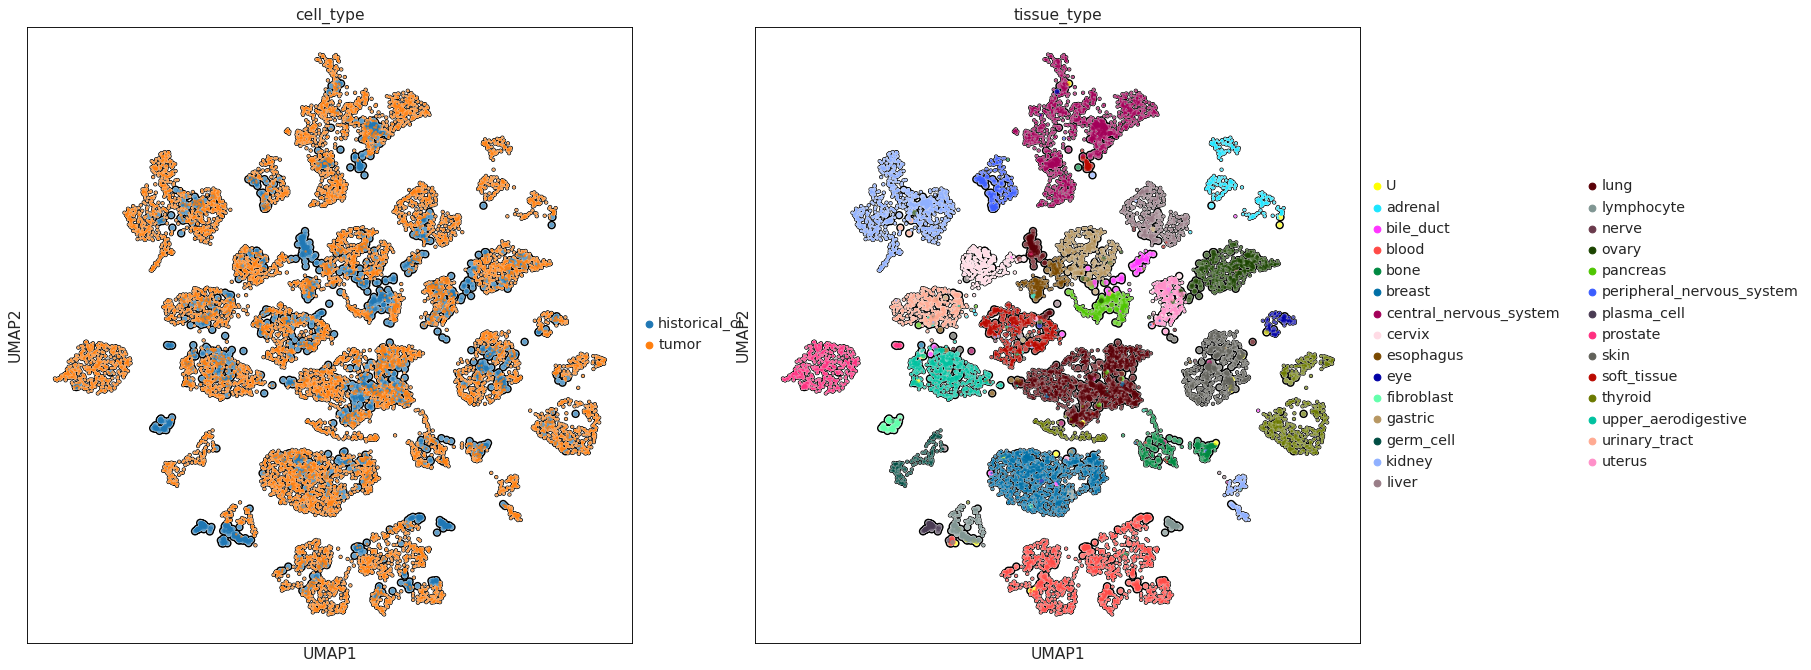

In [56]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['cell_type', 'tissue_type'],
        projection="2d",
        add_outline=True,
        size=[80]*len(dataset[dataset.obs['cell_type']=='historical_cl']) + [20]*len(dataset[dataset.obs['cell_type']=='tumor']))

/home/jeremie/celligner2/celligner2/plotting/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)


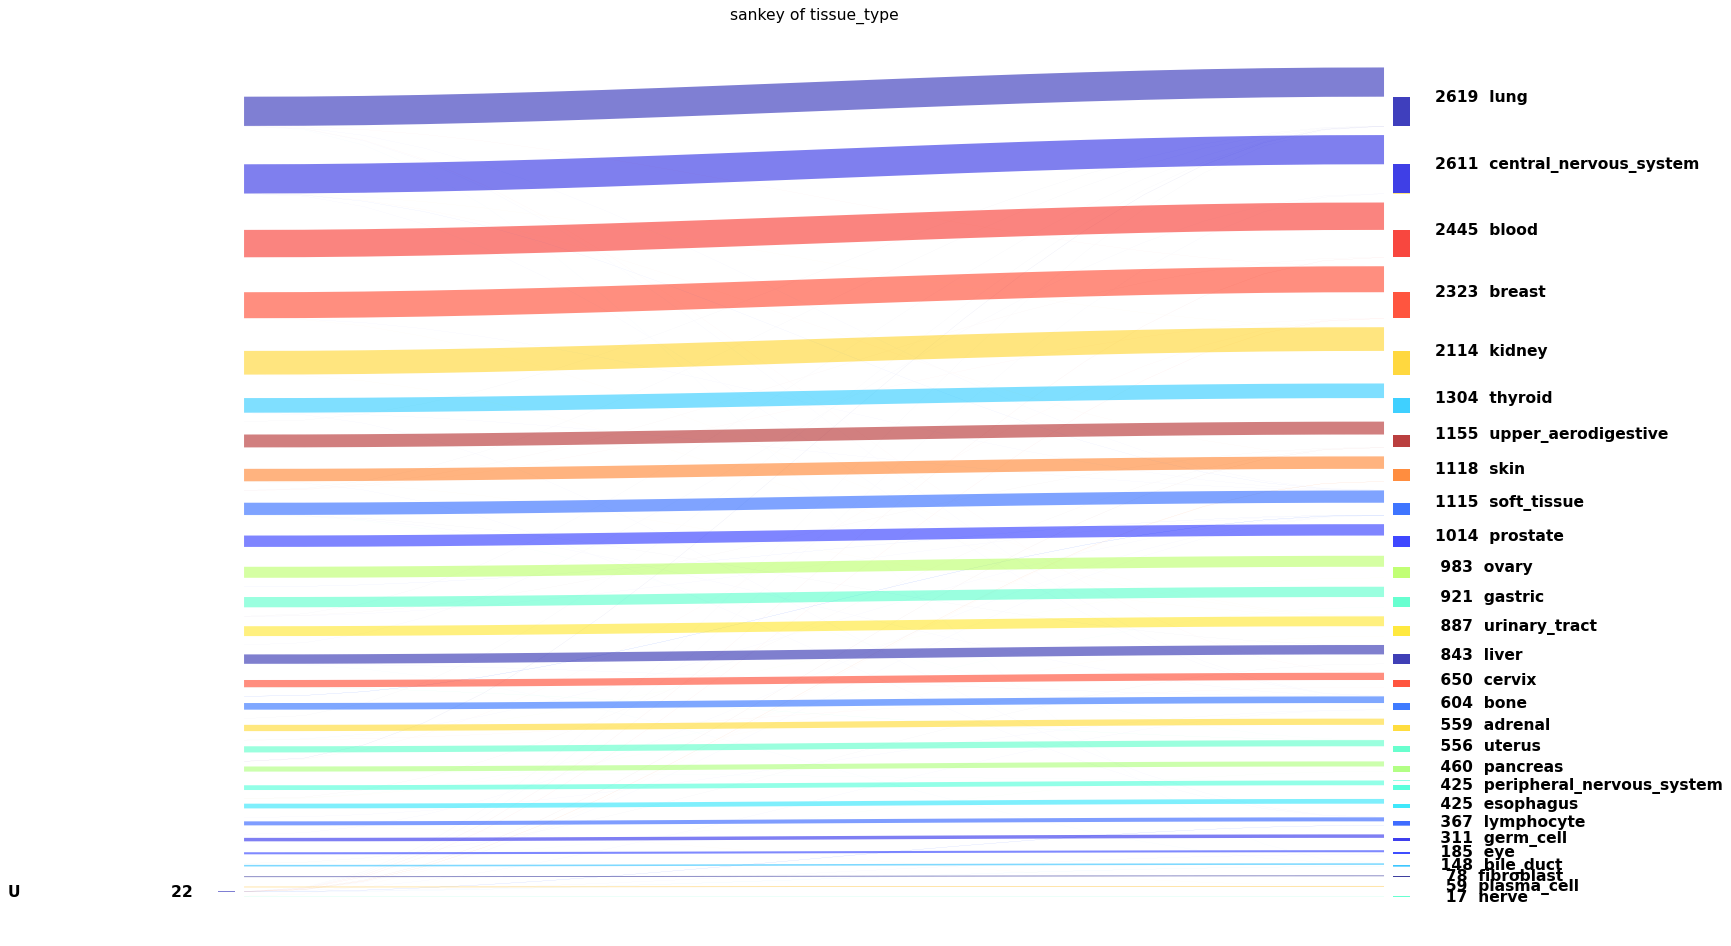

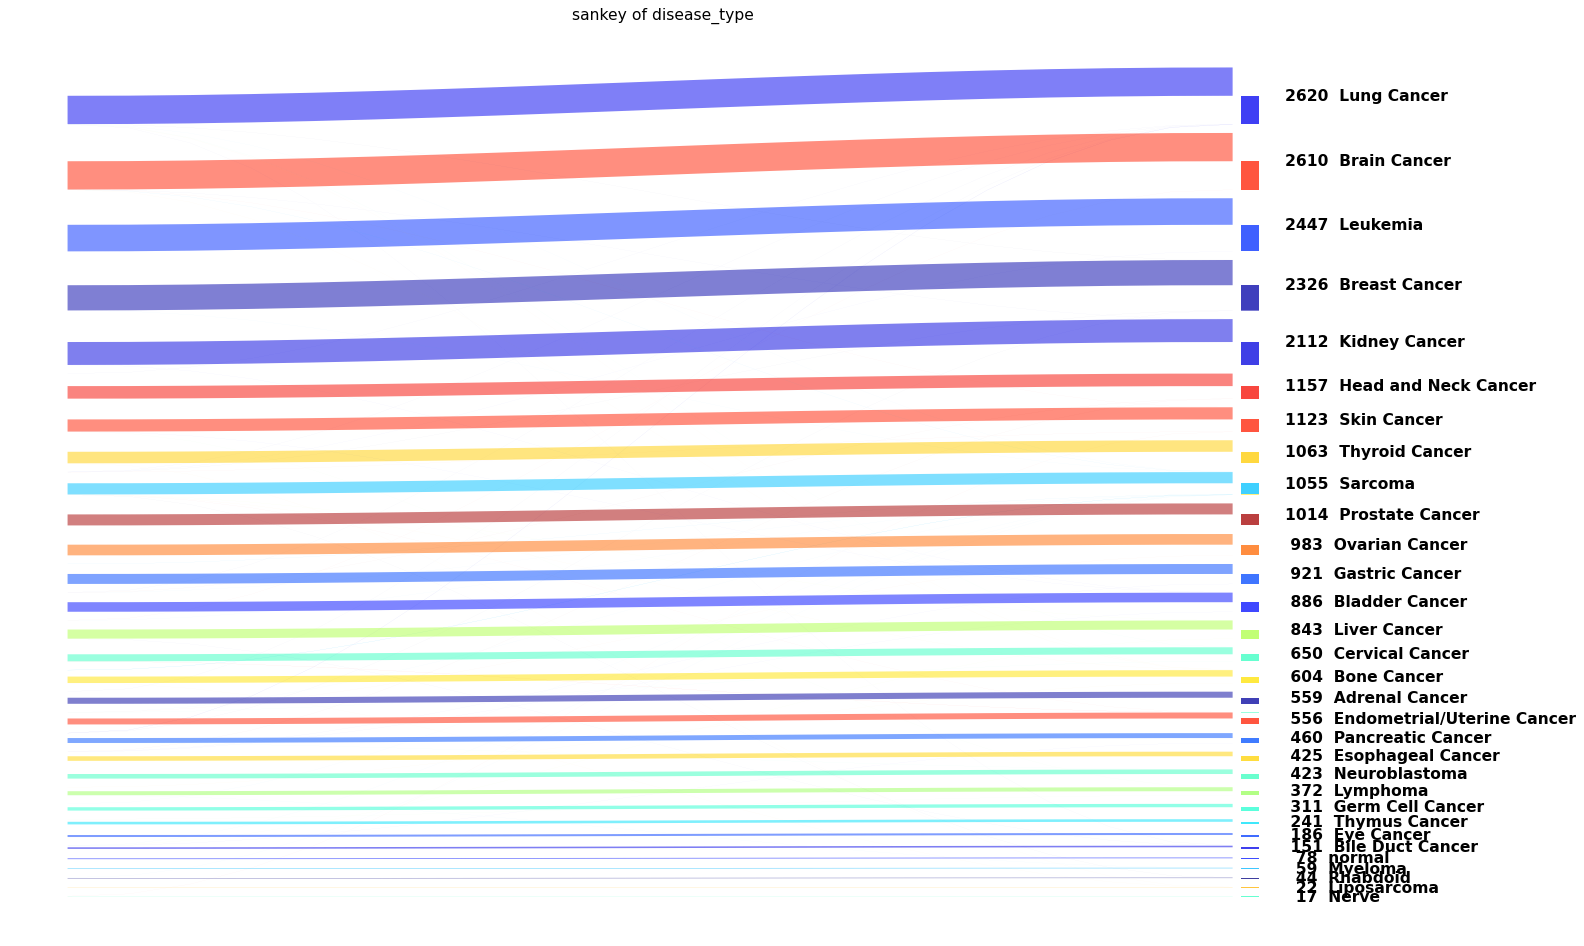

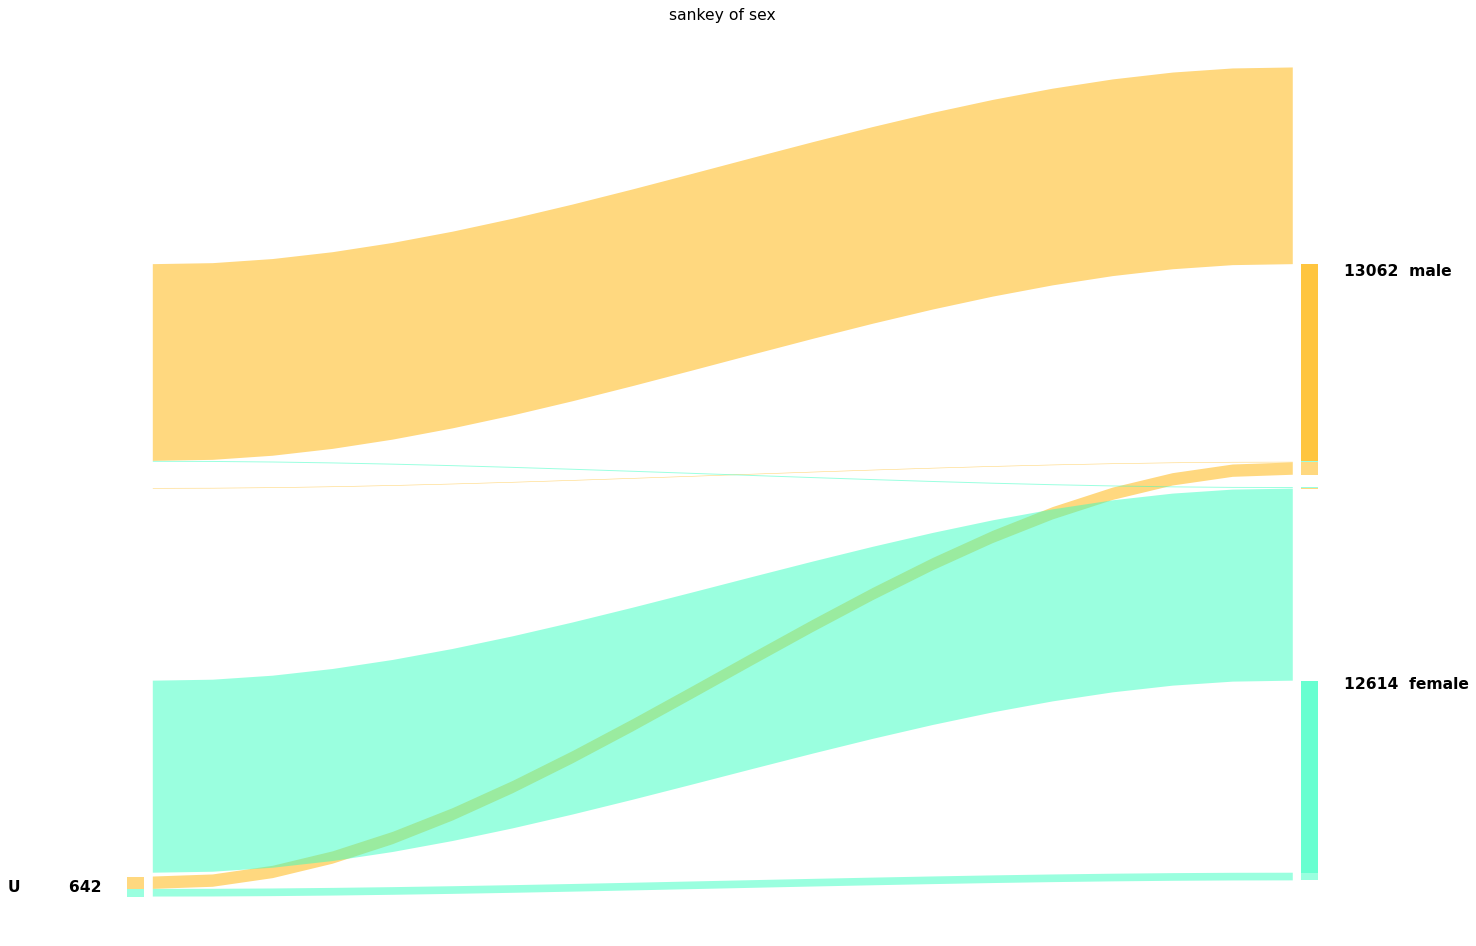

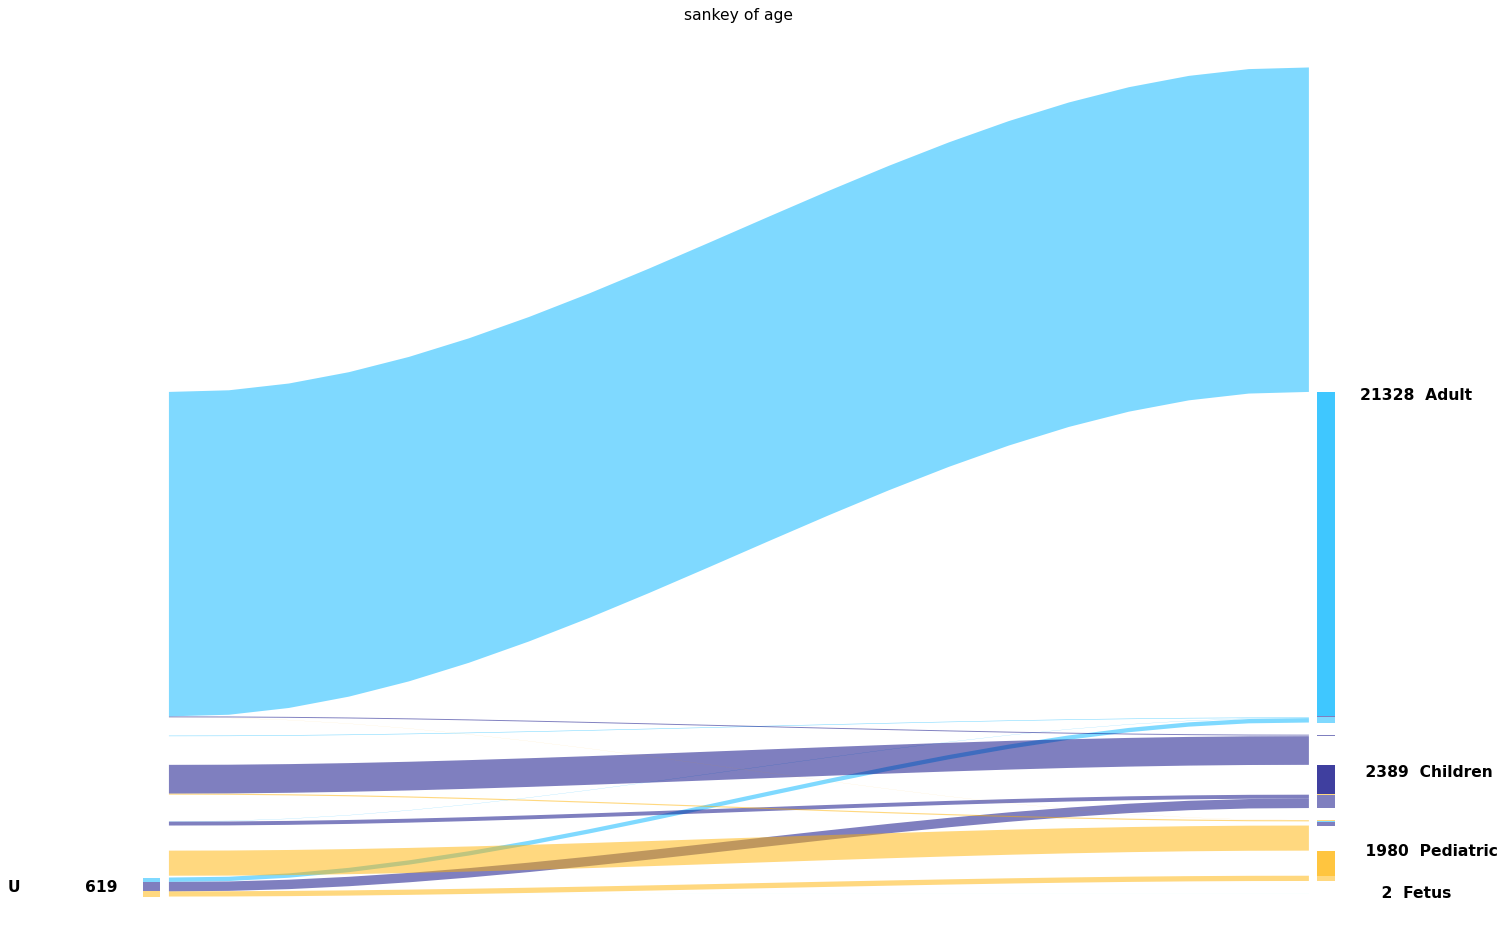

In [277]:
evaluator.plot_classification(classes=['tissue_type', 'disease_type', 'sex', 'age'])

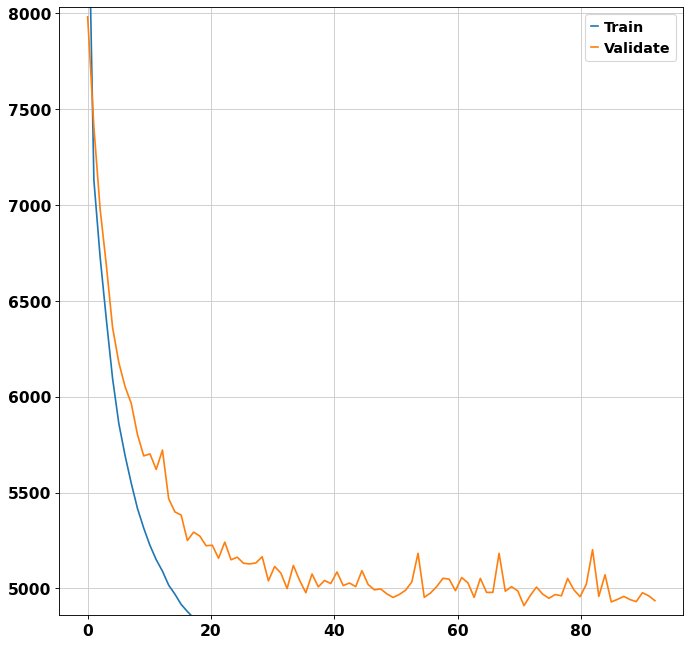

<Figure size 800x800 with 0 Axes>

In [285]:
evaluator.plot_history()

In [279]:
evaluator.get_asw()
evaluator.get_latent_score()
evaluator.get_nmi()

silhouette score...
ASW on batch: 0.8548363904456818
ASW on celltypes: 0.626011461019516
Calculating EBM with n_cat = 29
Latent-Space Score EBM+KNN, EBM, KNN: 0.93, 0.03, 0.90


ModuleNotFoundError: No module named 'louvain'

In [297]:
evaluator.adata_latent.shape

(13159, 16)

In [61]:
cl2=cl2_less

In [62]:
## what would it look like as tumor
#print(cl2_less.adata.obs.iloc[:100])
size = 20
cols = ['cell_type']#,'reference','sequencer', 'sample_type', 'align', 'counter']

tcga_cond = pd.DataFrame(data=[evaluator.adata_latent.obs.loc[evaluator.adata_latent.obs.cell_type=='tumor', cols].iloc[0].values.tolist()]*size, columns=cols)

ccle_cond = pd.DataFrame(data=[evaluator.adata_latent.obs.loc[evaluator.adata_latent.obs.cell_type=='historical_cl', cols].iloc[0].values.tolist()]*size, columns=cols)

reco_tumor = cl2.reconstruct(evaluator.adata_latent[:size].X, tcga_cond)
reco = cl2.reconstruct(evaluator.adata_latent[:size].X, ccle_cond)
true = cl2.adata[:size].X

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [63]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl2.adata.obs.iloc[:size], dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl2.adata.obs.iloc[:size], dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl2.adata.obs.iloc[:size], dataset.var)

In [64]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index]
coeff = pd.DataFrame(data=np.corrcoef(true.X, reco.X), columns = name, index = name)

<AxesSubplot:>

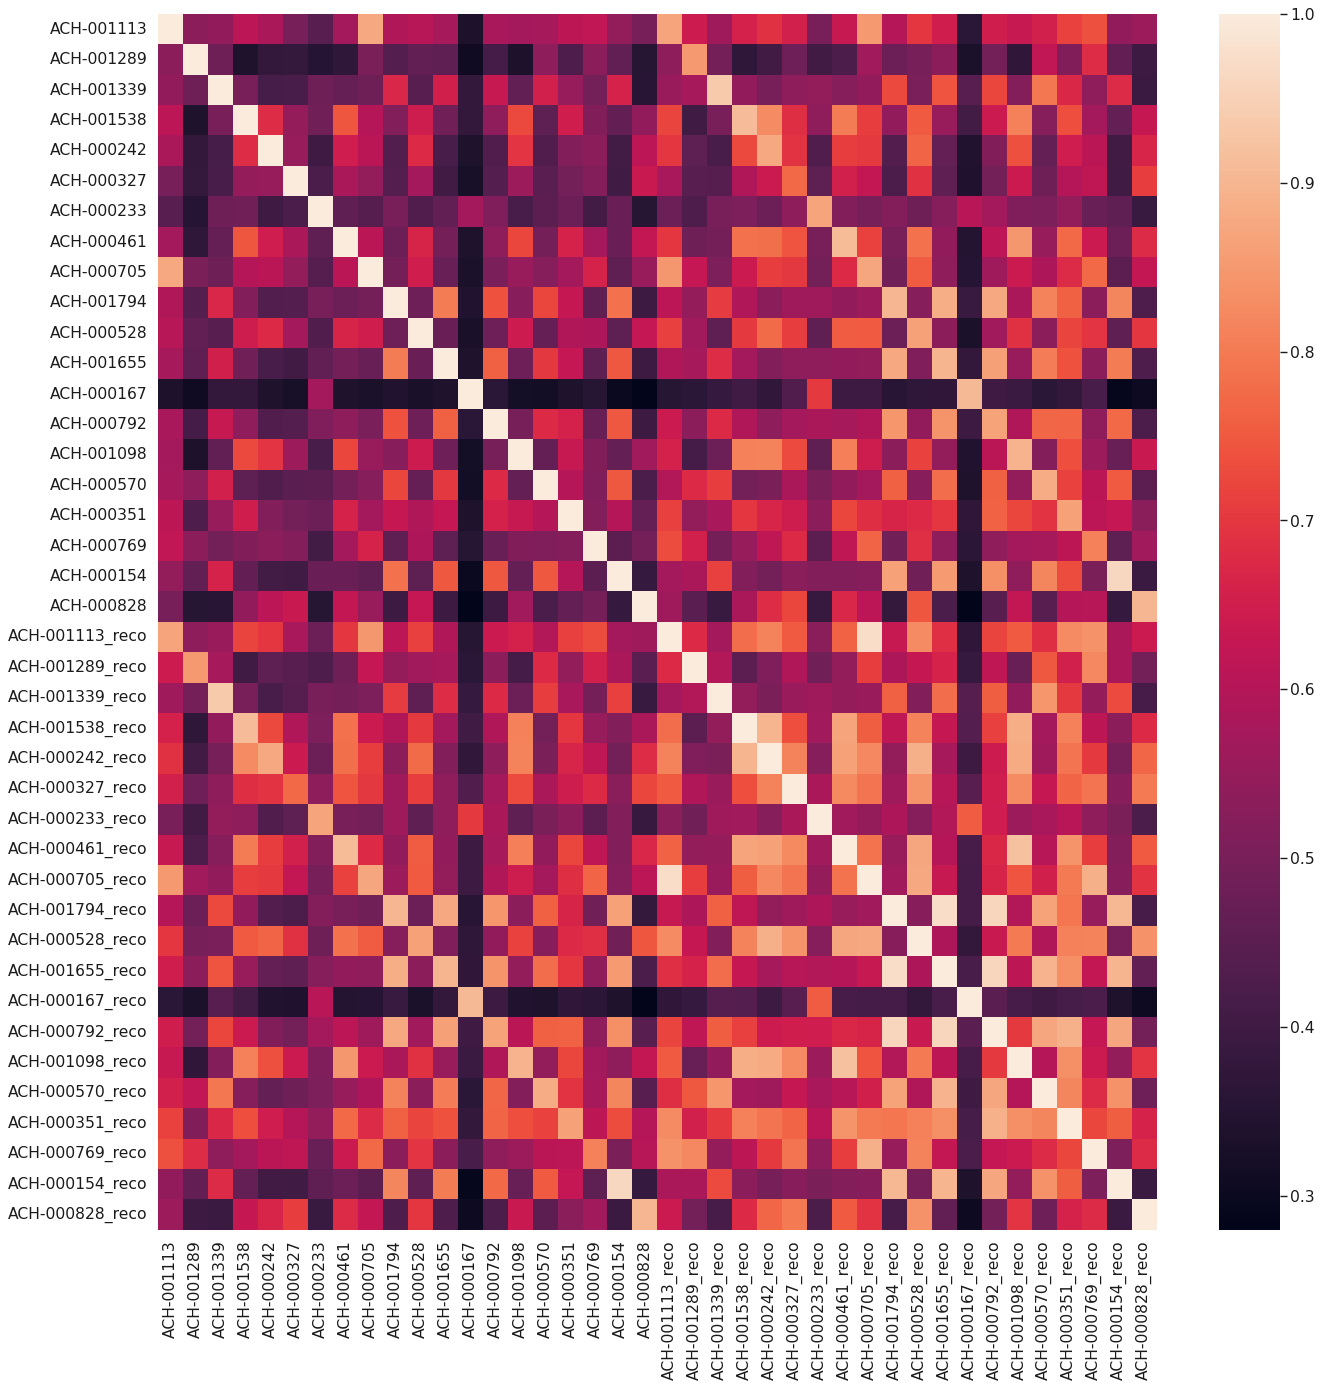

In [65]:
import seaborn as sns 
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

In [70]:
sa = cl2.adata.obs
clloc = sa[(sa.tissue_type=='gastric')&(sa.cell_type=='historical_cl')].index[:size]
tmloc = sa[(sa.tissue_type=='gastric')&(sa.cell_type=='tumor')].index[:size]

In [71]:
reco_tumor = cl2.reconstruct(evaluator.adata_latent[clloc].X, tcga_cond)
reco = cl2.reconstruct(evaluator.adata_latent[clloc].X, ccle_cond)
true = cl2.adata[clloc].X
tumor_eq = cl2.adata[tmloc].X

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [72]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl2.adata.obs.loc[clloc], dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl2.adata.obs.loc[clloc], dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl2.adata.obs.loc[clloc], dataset.var)
tumor_eq.columns = dataset.var.index
tumor_eq = AnnData(tumor_eq, cl2.adata.obs.loc[tmloc], dataset.var)

In [73]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index] + [i+"_reco_tumor" for i in reco.obs.index] + tumor_eq.obs.index.tolist()
coeff = pd.DataFrame(data=np.corrcoef(np.vstack([true.X,reco.X,reco_tumor.X, tumor_eq.X])), columns = name, index = name)

In [74]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],true.obs.index.tolist()].mean().mean()

0.5151769908357403

In [75]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],tumor_eq.obs.index.tolist()].mean().mean()

0.6242412798744692

In [76]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],[i+"_reco" for i in reco.obs.index]].mean().mean()

0.5947996357944135

<AxesSubplot:>

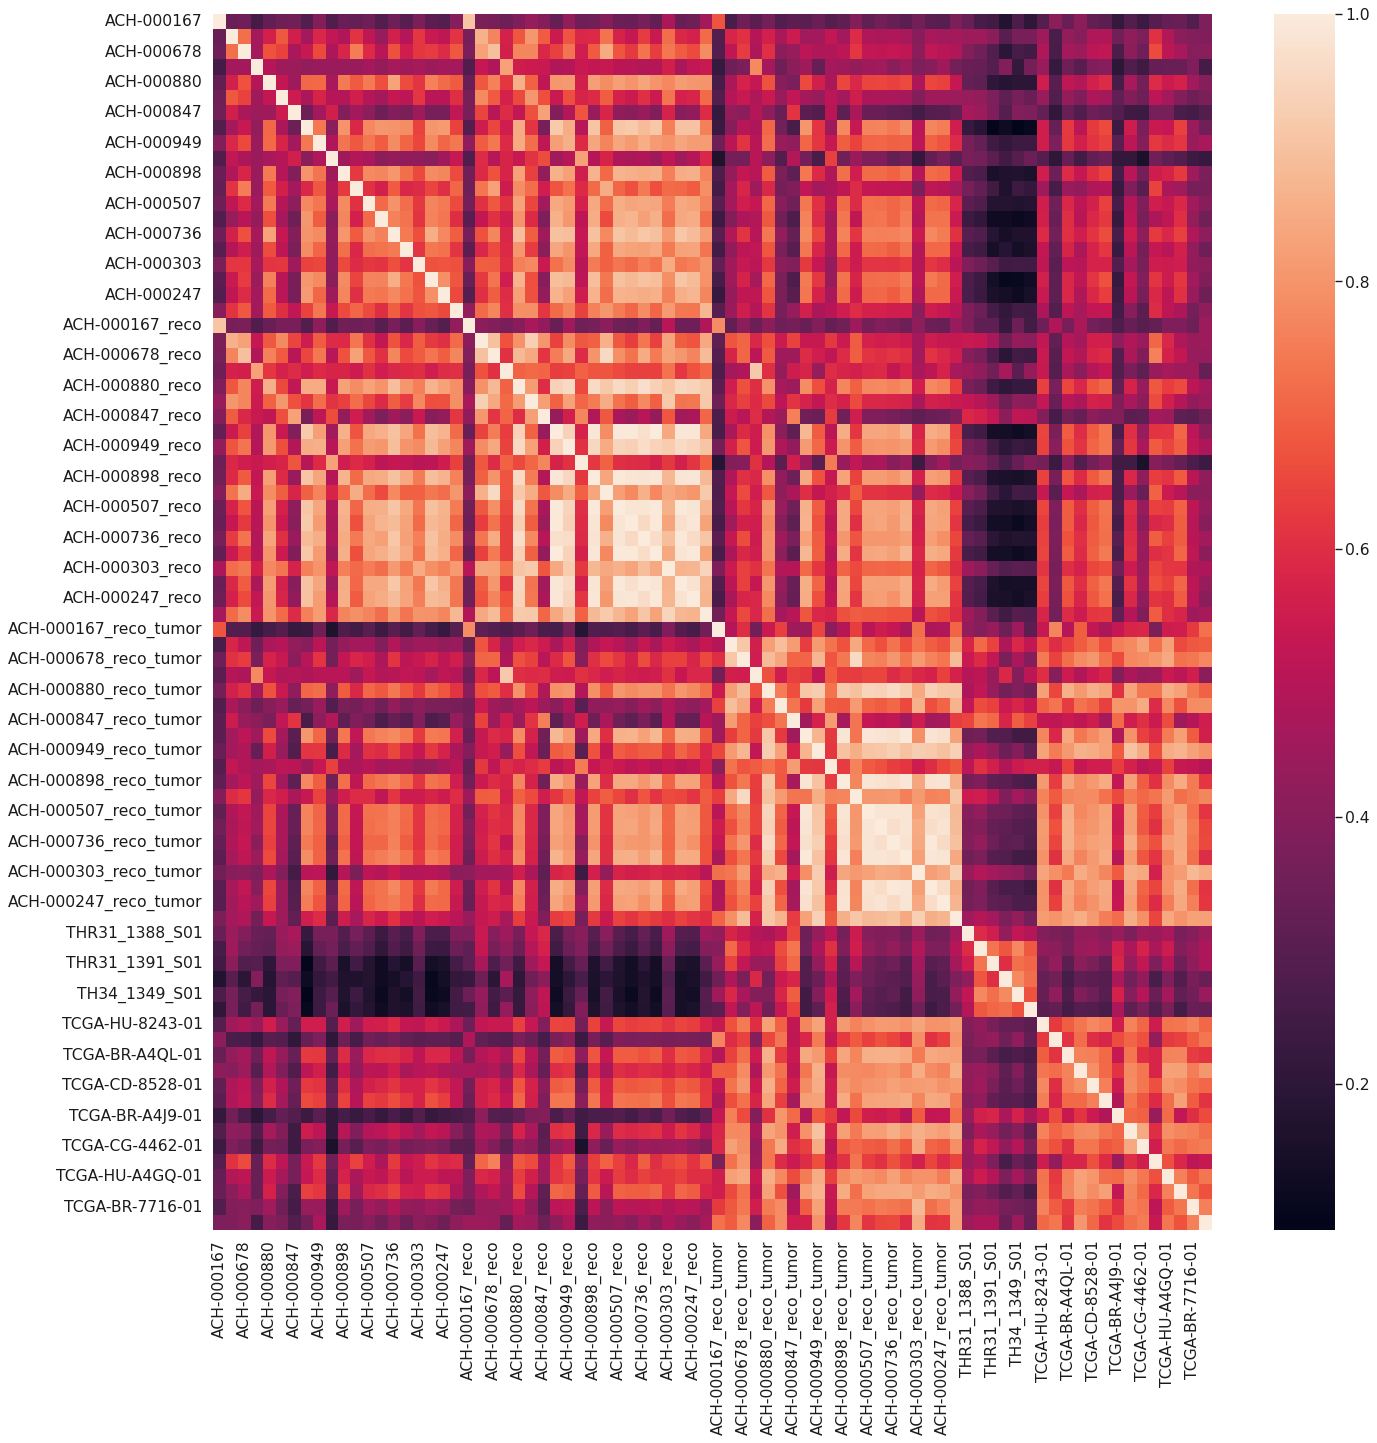

In [77]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

39,000,000 input 

811,852 parameter

## zenodo

In [ ]:
ACCESS_TOKEN = "YOURTOKEN"
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN,
                                             upload_type="other",
                                             title='Celligner2',
                                             description='test CL2 upload',
                                             creators=[
                                                 {"name": "Jeremie, Kalfon", 
                                                  "affiliation": "Broad Institute", 
                                                  "orcid": ""},
                                             ]
                                             )

In [ ]:
download_link = sca.zenodo.upload_model('./model/cl2',
                                        deposition_id=deposition_id,
                                        access_token=ACCESS_TOKEN,
                                        model_name='CL2')

In [ ]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

In [ ]:
model_path = sca.zenodo.download_model(download_link, './surg_model/', make_dir=True)
new_cl2 = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=model_path)

## add many many more datasets